# Few-shot learning - Omniglot - Fellowship.ai

## Context

#### Fellowship.ai - Few-shot learning
This is my personal project to the few-shot learning challenge from [Fellowship.ai](https://fellowship.ai/challenge/) with the following goal:
> Omniglot, the “transpose” of MNIST, with 1623 character classes, each with 20 examples.  Build a few-shot classifier with a target of <35% error.

#### Omniglot - Dataset
*Dataset reference:* [Link](https://github.com/brendenlake/omniglot)
> Lake, B. M., Salakhutdinov, R., and Tenenbaum, J. B. (2015). Human-level concept learning through probabilistic program induction. Science, 350(6266), 1332-1338.

The Omniglot dataset is often considered as the transpose of the MNIST dataset. While the latter contains only 10 classes with a training set of 60000 examples, Omniglot contains an important number of classes (1623 different handwritten characters from 50 different alphabets) with only a low number of examples (20) for each, making it an ideal dataset for few-shot learning problems.

#### Few-shot learning
Whereas, lots of deep learning projects are based on a huge number of training examples to be trained, few-shot learning is  based only on a few one. This approach is much closer to the one experienced by humans. We are able to memorize and recognize objects we have never seen before from a few number of examples. Then for each new encounter with these types of object we can classify them in an accurate and easy way.


#### Stategy





## Main Goal

### Import libraries

In [1]:
import os

import tensorflow as tf
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, concatenate, MaxPooling2D, Dropout, Lambda
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

from PIL import Image                                                                                                                               
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.transform import resize
import h5py


%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### PATH

We indicate the PATH of the training examples.

In [2]:
#Training images path
PATH="images_background/"

### Data Analysis

We have a look at the list of all alphabets contained in the training set, and their total number.

In [3]:
alph_type = np.array(os.listdir(PATH)) #Give the different types of alphabet in our data
print("List of the different alphabets:\n\n {}".format(alph_type))
print("\nNumber of different alphabets: {}".format(len(alph_type)))

List of the different alphabets:

 ['Alphabet_of_the_Magi' 'Anglo-Saxon_Futhorc' 'Arcadian' 'Armenian'
 'Asomtavruli_(Georgian)' 'Balinese' 'Bengali'
 'Blackfoot_(Canadian_Aboriginal_Syllabics)' 'Braille' 'Burmese_(Myanmar)'
 'Cyrillic' 'Early_Aramaic' 'Futurama' 'Grantha' 'Greek' 'Gujarati'
 'Hebrew' 'Inuktitut_(Canadian_Aboriginal_Syllabics)'
 'Japanese_(hiragana)' 'Japanese_(katakana)' 'Korean' 'Latin'
 'Malay_(Jawi_-_Arabic)' 'Mkhedruli_(Georgian)' 'N_Ko'
 'Ojibwe_(Canadian_Aboriginal_Syllabics)' 'Sanskrit' 'Syriac_(Estrangelo)'
 'Tagalog' 'Tifinagh']

Number of different alphabets: 30


We then check the number of character for each alphabets.

In [4]:
alph_num_char ={}
for alphabet in alph_type:
    alph_num_char[alphabet]= len(os.listdir(f'{PATH}{alphabet}'))
print("The number of chracters corresponding to each alphabet is : \n{}".format(alph_num_char))

num_of_char = alph_num_char.values()
print('\nThe maximum number of different character for one alphabet is {}'.format(max(num_of_char)))
print('The minimum number of different character for one alphabet is {}'.format(min(num_of_char)))
total_char = sum(num_of_char)
print('The total number of different character is {}'.format(total_char))

The number of chracters corresponding to each alphabet is : 
{'Alphabet_of_the_Magi': 20, 'Anglo-Saxon_Futhorc': 29, 'Arcadian': 26, 'Armenian': 41, 'Asomtavruli_(Georgian)': 40, 'Balinese': 24, 'Bengali': 46, 'Blackfoot_(Canadian_Aboriginal_Syllabics)': 14, 'Braille': 26, 'Burmese_(Myanmar)': 34, 'Cyrillic': 33, 'Early_Aramaic': 22, 'Futurama': 26, 'Grantha': 43, 'Greek': 24, 'Gujarati': 48, 'Hebrew': 22, 'Inuktitut_(Canadian_Aboriginal_Syllabics)': 16, 'Japanese_(hiragana)': 52, 'Japanese_(katakana)': 47, 'Korean': 40, 'Latin': 26, 'Malay_(Jawi_-_Arabic)': 40, 'Mkhedruli_(Georgian)': 41, 'N_Ko': 33, 'Ojibwe_(Canadian_Aboriginal_Syllabics)': 14, 'Sanskrit': 42, 'Syriac_(Estrangelo)': 23, 'Tagalog': 17, 'Tifinagh': 55}

The maximum number of different character for one alphabet is 55
The minimum number of different character for one alphabet is 14
The total number of different character is 964


In [5]:
alph_num_char_ex={}
class_num=0
for alphabet in alph_type:
    char_list=os.listdir(f'{PATH}{alphabet}')
    for char in char_list:
        alph_num_char_ex[(alphabet,char)]= len(os.listdir(f'{PATH}{alphabet}/{char}'))

num_of_example = alph_num_char_ex.values()
print('The maximum number of different examples for one character is {}'.format(max(num_of_example)))
print('The minimum number of different examples for one character is {}'.format(min(num_of_example)))
total_example = sum(num_of_example) 
print('The total number of different pictures is {}'.format(total_example))

The maximum number of different examples for one character is 20
The minimum number of different examples for one character is 20
The total number of different pictures is 19280


We can observe that each character have 20 examples(pictures).

### Add label for each character


For each picture in our dataset we give a corresponding label(an integer) which allow us to determine the corresponding character. Here an integer is sufficient as we are not really interested in knowing from which alphabet an image is coming from and as we don't have need to know the character name.

In [6]:
class_char=np.array([])
for i in range(total_char):
    #As each character have 20 examples
    class_char= np.concatenate((class_char, np.ones(20)*(i+1))) 
class_char = class_char.astype(int)
print(class_char.shape)

(19280,)


We reshape, our data to have the number of channel including (here is 1).

In [7]:
class_char=class_char.reshape(class_char.shape[0],1)
print(class_char.shape)

(19280, 1)


### Convert images to datafile

We first retrieve the path for each picture in the dataset.

In [8]:
imagePath = glob.glob("{}*/*/*.png".format(PATH))
imagePath[0:5]

['images_background\\Alphabet_of_the_Magi\\character01\\0709_01.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_02.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_03.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_04.png',
 'images_background\\Alphabet_of_the_Magi\\character01\\0709_05.png']

We print some random images of the dataset, convert them to arrays and resize them.

In [9]:
#We decide to resize our images to the following 

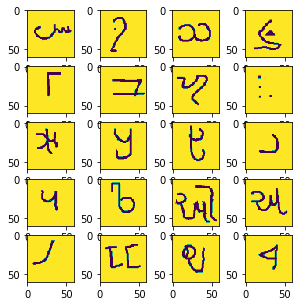

In [11]:
imagePath = glob.glob("{}*/*/*.png".format(PATH))

SZ=60 #Dimension of the output image expected

#Dimensions of the grill of sample pictures
columns = 4
rows = 5

fig=plt.figure(figsize=(5, 5))
list_example = np.random.randint(total_example, size = columns*rows)
pos=0
for i in list_example:
    pos+=1
    img = mpimg.imread(imagePath[i])
    img = resize(img, (SZ,SZ), mode='reflect')
    fig.add_subplot(rows, columns, pos)
    plt.imshow(img)
plt.show()

All images seems clear and well centered.

### Image conversion

We convert all images into arrays and resize them to the 60x60 format. We concatenate all arrays into the variable im_array

In [13]:
#Transform in array and resize all 19280 images 
im_array = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='reflect') for i in imagePath] )
print (im_array.shape)

(19280, 60, 60)


We reshape the image to take into account the number of channel to pass them in our CNN, which is 1 here.

In [14]:
channel_sz = 1 #number of channel
im_array= im_array.reshape(im_array.shape[0],im_array.shape[1],im_array.shape[2],channel_sz)
print(im_array.shape)

(19280, 60, 60, 1)


### Split Train/ validation


We split the traning set into Train and Validation sets of pictures (Train : 70%, Validation : 3O%)

In [15]:
X_train, X_valid, Y_train, Y_valid = train_test_split(im_array, class_char, test_size=0.3, stratify= class_char)

In [16]:
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((13496, 60, 60, 1), (5784, 60, 60, 1), (13496, 1), (5784, 1))

### Triplet loss function

Our loss function is determined by the following triplet loss function

In [17]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 64)
            positive -- the encodings for the positive images, of shape (None, 64)
            negative -- the encodings for the negative images, of shape (None, 64)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[:,0:64], y_pred[:,64:128], y_pred[:,128:256]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

Triplet Creation

In [23]:
def create_triplets(X, Y, num=1):
    """
    Create a list of valid triplets
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    num -- number of negative images for each valid anchor and positive images - must be positive
           if num = 0, all possible valid couples are created
            For example : for one valid (A,P) couple we can select 'num' random N images. 
                          Thus 'num' triplets are created for this (A,P) couple

    
    Returns:
    (A,P,N) -- python tuple containing 3 arrays : 
            A -- the array for the anchor images, of shape (None, 64)
            P -- the array for the positive images, of shape (None, 64)
            N -- the array for the negative images, of shape (None, 64)
    """

    Y = Y.reshape(Y.shape[0],)
    A = []
    P = []
    N = []
    
    #We loop over all possible valid (A,P)
    for i in range(X.shape[0]):  
        list_pos = X[Y==Y[i]]
        for j in list_pos:
            #We provide a number 'num' of triplets for each valid (A,P)
            if num >=1:
                for k in range(num):
                    rand_num = np.random.randint(X.shape[0])
                    if np.array_equal(X[i],j) == False:
                        A.append(X[i])
                        P.append(j)
                        while np.array_equal(Y[rand_num], Y[i]):
                            rand_num = np.random.randint(X.shape[0])
                        N.append(X[rand_num])
            if num == 0:
                for k in range(X.shape[0]):
                    if np.array_equal(X[i],j) == False:
                        if np.array_equal(Y[i],Y[k]) == False:
                            A.append(X[i])
                            P.append(j)
                            N.append(X[k])
    
    A = np.array(A)
    P = np.array(P)
    N = np.array(N)
    
    return (A, P, N)

In [24]:
#We create one triplet for each of the possible (A,P) couple in our validation set 
triplets_list_valid = create_triplets(X_valid,Y_valid)
for i in range(len(triplets_list_valid)):
    print(triplets_list_valid[i].shape)

(28920, 60, 60, 1)
(28920, 60, 60, 1)
(28920, 60, 60, 1)


This gives us a number of 28920 examples for the validation. Thus 1 negative image per (A,P) couple is enough for our evaluation set.

### Model creation

In [25]:
def EmbModel(input_shape):
    """
    Define our shared embedding model
    
    Arguments:
    input_shape -- shape of array of input images

    
    Returns:
    model - Our model which transform an array of images into an array of embeddings
    """
    
    
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape)
    
    #Padding
    X = ZeroPadding2D((1,1))(X_input)
    
    #CONV
    X = Conv2D(8,(3,3),strides =(1,1), name ='conv0', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn0") (X)
    X = Activation('relu', name='a0')(X)
    
    #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool0')(X)
    
    X = Dropout(0.15)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(16,(3,3),strides =(1,1), name ='conv1', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn1") (X)
    X = Activation('relu', name='a1')(X)
    
    #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool1')(X)
    
    X = Dropout(0.15)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(32,(3,3),strides =(1,1), name ='conv2', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn2") (X)
    X = Activation('relu', name='a2')(X)
    
     #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool2')(X)
    
    X = Dropout(0.15)(X)
    
    #Padding
    #X = ZeroPadding2D((1,1))(X)
    
     #CONV
    X = Conv2D(64,(3,3),strides =(1,1), name ='conv3', kernel_initializer='glorot_uniform') (X)
    X = BatchNormalization(axis = 1, name = "bn3") (X)
    X = Activation('relu', name='a3')(X)
    
     #MAXPOOL
    X = MaxPooling2D((2,2), name='max_pool3')(X)
    
    X = Dropout(0.2)(X)
    
    #FLATTEN X + FC
    X = Flatten(name='f3')(X)
    X = Dense (256, activation ='relu', name='fc4', kernel_initializer='glorot_uniform') (X)
    X = Dropout(0.3)(X)
    X = Dense (64, activation ='relu', name='fc5', kernel_initializer='glorot_uniform') (X)
    X = Lambda(lambda  x: tf.nn.l2_normalize(x,axis=1))(X)
    
    ##Create model
    model = Model(inputs = X_input, outputs = X, name='EmbModel')
    
    return model

#### Global model

In [26]:
#We define our global model
input_size = (SZ, SZ, channel_sz)                     

A = Input(input_size)
P = Input(input_size)
N = Input(input_size)

emb_model= EmbModel(input_size)

out_A = emb_model(A)
out_P = emb_model(P)
out_N = emb_model(N)

y_pred = concatenate([out_A, out_P, out_N], axis =-1)

classification_model = Model(inputs = [A, P, N], outputs = y_pred)

In [27]:
classification_model.summary()
emb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 60, 60, 1)    0                                            
__________________________________________________________________________________________________
EmbModel (Model)                (None, 64)           107040      input_1[0][0]                    
                                                                 input_2[0][0]                    
          

## Batch Generator

In [28]:
def batch_generator(X,Y, bs=32):
    """
    Create a mini-batch generator
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    bs -- size of the minibatch

    
    Returns:
    [A_batch, P_batch, N_batch], y_dummie) -- a mini-batch of size bs
    """
    
    Y = Y.reshape(Y.shape[0],)
    while True:
        #0. Initialize Anchor,Postive, Negative
        A_batch = []
        P_batch = []
        N_batch = []
        for i in range(bs):      
            #1.Choose a random Anchor Image
            rand_A_num = np.random.randint(X.shape[0])
            A_batch.append(X[rand_A_num])
            
            #2.Choose a random Positive Image
            list_pos = X[Y==Y[rand_A_num]]                            #List of positive images
            rand_P_num = np.random.randint(len(list_pos))
            P_batch.append(list_pos[rand_P_num])
            
            #3.Choose a random Negative Image
            rand_N_num = np.random.randint(X.shape[0])
            while np.array_equal(Y[rand_N_num], Y[rand_A_num]):
                rand_A_num = np.random.randint(X.shape[0])
            N_batch.append(X[rand_N_num])
            
        A_batch = np.array(A_batch)
        P_batch = np.array(P_batch)
        N_batch = np.array(N_batch)
        
        y_dummie = np.zeros((len(A_batch),))
        
        yield ([A_batch, P_batch, N_batch], y_dummie)

## Real shit

In [29]:
#We compile our model with the custom made triplet_loss
classification_model.compile(optimizer = 'adam', loss = triplet_loss)

### Checkpoint and early stop

In [30]:
#We create a checkpoint to save the best model and add an early stopping
filepath = "Weights\weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks_list = [checkpoint, early_stop]

In [31]:
A_valid, P_valid, N_valid = triplets_list_valid
zeros_vect_valid = np.zeros(A_valid[:,1,1].shape) 

batch_sz = 1024

classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz), 
                                   steps_per_epoch = 172,
                                   epochs = 1,
                                   verbose = 1,
                                   validation_data = ([A_valid, P_valid, N_valid], zeros_vect_valid),
                                  )


Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[1024,16,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: EmbModel_1/conv1/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](EmbModel_1/dropout_1/cond/Merge, conv1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_917 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_5511_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'EmbModel_1/conv1/convolution', defined at:
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-3e05ee646c44>", line 11, in <module>
    out_P = emb_model(P)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\keras\engine\topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\keras\engine\topology.py", line 2236, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\keras\layers\convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\keras\backend\tensorflow_backend.py", line 3335, in conv2d
    data_format=tf_data_format)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 782, in convolution
    return op(input, filter)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 870, in __call__
    return self.conv_op(inp, filter)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 522, in __call__
    return self.call(inp, filter)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 206, in __call__
    name=self.name)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1039, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tensorflow\python\framework\ops.py", line 3290, in create_op
    op_def=op_def)
  File "C:\Users\Xyrion\Anaconda3\envs\fastai\lib\site-packages\tensorflow\python\framework\ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1024,16,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: EmbModel_1/conv1/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](EmbModel_1/dropout_1/cond/Merge, conv1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/mul/_917 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_5511_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [42]:
batch_sz = 32

classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz), 
                                   steps_per_epoch = 1,
                                   epochs = 20,
                                   verbose = 1,
                                   validation_data = ([A_valid, P_valid, N_valid], zeros_vect_valid),
                                   callbacks = callbacks_list
                                  )

Epoch 1/20
1/1 [==============================] - 32s 32s/step - loss: 0.3644 - val_loss: 3.8890

Epoch 00001: val_loss improved from inf to 3.88902, saving model to Weights\weights.01-3.89.hdf5
Epoch 2/20


KeyboardInterrupt: 

In [33]:
classification_model.load_weights("weights.03-0.10.hdf5")

### Return

Comparison with Modified Hausdorff Distance

In [34]:
from demo_classification import *

In [39]:
def CNNDistance(itemA, itemB):
    itemA = itemA.reshape(1, itemA.shape[0], itemA.shape[1], 1)
    itemB = itemB.reshape(1, itemB.shape[0], itemB.shape[1], 1)
    itemA_emb = emb_model.predict_on_batch(itemA)
    itemB_emb = emb_model.predict_on_batch(itemB)
    dist = np.linalg.norm(itemA_emb - itemB_emb)
    return dist

In [40]:
def LoadImgAsArray(fn):
	# Load image file, return as array and resize
    picture = mpimg.imread(fn)
    image = resize(picture, (SZ,SZ), mode='constant')
    return image

In [41]:
print ('One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance')
perror = np.zeros(nrun)
perror_cnn =np.zeros(nrun)
for r in range(1,nrun+1):
	rs = str(r)
	if len(rs)==1:
		rs = '0' + rs		
	perror[r-1] = classification_run('one-shot-classification','/run'+rs, LoadImgAsPoints, ModHausdorffDistance, 'cost')
	perror_cnn[r-1] = classification_run('one-shot-classification','run'+rs, LoadImgAsArray, CNNDistance, 'cost')
	print (" run " + str(r) + " ModHausdorffDistance" + "(error " + str(	perror[r-1] ) + "%)"+ "  -  Siamese_triplet_loss_Distance" + " (error " + str(	perror_cnn[r-1] ) + "%)")		
total = np.mean(perror)
total_cnn = np.mean(perror_cnn)
print (" average error ModHausdorffDistance " + str(total) + "%" + "  average error Siamese_triplet_loss_Distance " + str(total_cnn) + "%")

One-shot classification with Modified Hausdorff Distance versus Siamese triplet loss Distance
 run 1 ModHausdorffDistance(error 45.0%)  -  Siamese_triplet_loss_Distance (error 30.0%)
 run 2 ModHausdorffDistance(error 35.0%)  -  Siamese_triplet_loss_Distance (error 30.0%)


KeyboardInterrupt: 